In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, auc
from IPython.display import clear_output
import os
import shutil
import re
from datetime import datetime, timedelta
import seaborn as sns
from jDataResultsAnalysis import explore_data_results, compare_data_results

/home/jaleedkhan/.conda/envs/patchctg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Analyzing Datasets

In [9]:
dataset_path = "ctg_dataset/Old Dataset/"
#dataset_path = "ctg_dataset/Old Dataset (Cases Diff 3-7)/"
#dataset_path = "ctg_dataset/Old Dataset (Cases Diff 0-2)/"
#dataset_path = "ctg_dataset/Dataset with Folds/model_datasets/fold_0"

def min_max_normalize(signal, min_value, max_value):
    valid_mask = signal != -1 # Create a mask for non-missing values (-1 are missing values)
    signal[valid_mask] = (signal[valid_mask] - min_value) / (max_value - min_value) # Apply normalization only to valid values
    return signal

FHR range (excluding -1s): 50.0 - 240.0 ; -1s (%): 0.34502509461072994
TOCO range (excluding -1s): 0.0 - 100.0 ; -1s (%): 0.33759777285329773


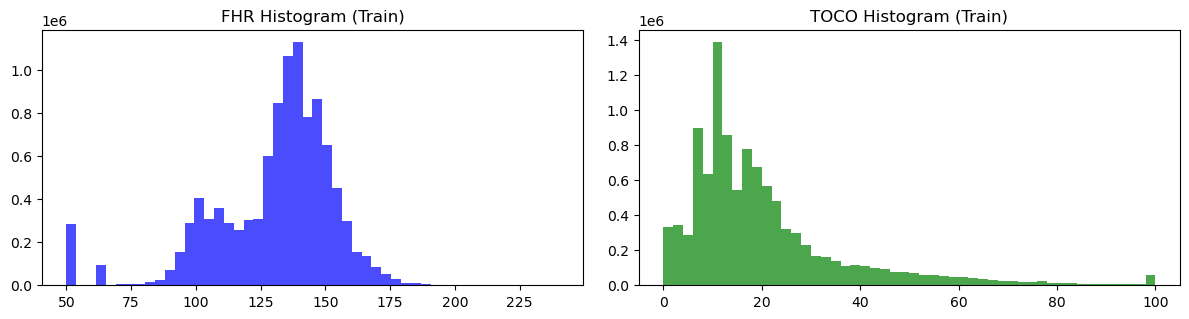

In [10]:
# Load the dataset
X_train_fhr = np.load(os.path.join(dataset_path, 'X_train_fhr.npy'))
X_train_toco = np.load(os.path.join(dataset_path, 'X_train_toco.npy'))
y_train = np.load(os.path.join(dataset_path, 'y_train.npy'))
clinical_train = pd.read_csv(os.path.join(dataset_path, 'clinical_train.csv'))
X_val_fhr = np.load(os.path.join(dataset_path, 'X_val_fhr.npy'))
X_val_toco = np.load(os.path.join(dataset_path, 'X_val_toco.npy'))
y_val = np.load(os.path.join(dataset_path, 'y_val.npy'))
clinical_val = pd.read_csv(os.path.join(dataset_path, 'clinical_val.csv'))

# Adjust ranges while ignoring -1s
X_train_fhr = np.where((X_train_fhr != -1) & (X_train_fhr < 50.0), 50.0, X_train_fhr)
X_train_fhr = np.where((X_train_fhr != -1) & (X_train_fhr > 240.0), 240.0, X_train_fhr)
X_val_fhr = np.where((X_val_fhr != -1) & (X_val_fhr < 50.0), 50.0, X_val_fhr)
X_val_fhr = np.where((X_val_fhr != -1) & (X_val_fhr > 240.0), 240.0, X_val_fhr)
X_train_toco = np.where((X_train_toco != -1) & (X_train_toco > 100.0), 100.0, X_train_toco)
X_val_toco = np.where((X_val_toco != -1) & (X_val_toco > 100.0), 100.0, X_val_toco)

# Filter out the -1 values for range calculations and plotting
valid_fhr_train = X_train_fhr[X_train_fhr != -1]
valid_toco_train = X_train_toco[X_train_toco != -1]
print('FHR range (excluding -1s):', np.min(valid_fhr_train), '-', np.max(valid_fhr_train),
      '; -1s (%):', np.sum(X_train_fhr == -1) / X_train_fhr.size)
print('TOCO range (excluding -1s):', np.min(valid_toco_train), '-', np.max(valid_toco_train),
      '; -1s (%):', np.sum(X_train_toco == -1) / X_train_toco.size)

# Plot histograms, excluding -1 values for FHR and TOCO
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.hist(valid_fhr_train.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('FHR Histogram (Train)')
plt.subplot(2, 2, 2)
plt.hist(valid_toco_train.flatten(), bins=50, color='green', alpha=0.7)
plt.title('TOCO Histogram (Train)')
plt.tight_layout()
plt.show()

FHR range (excluding -1s): 0.0 - 1.0 ; -1s (%): 0.34502509461072994
TOCO range (excluding -1s): 0.0 - 1.0 ; -1s (%): 0.33759777285329773


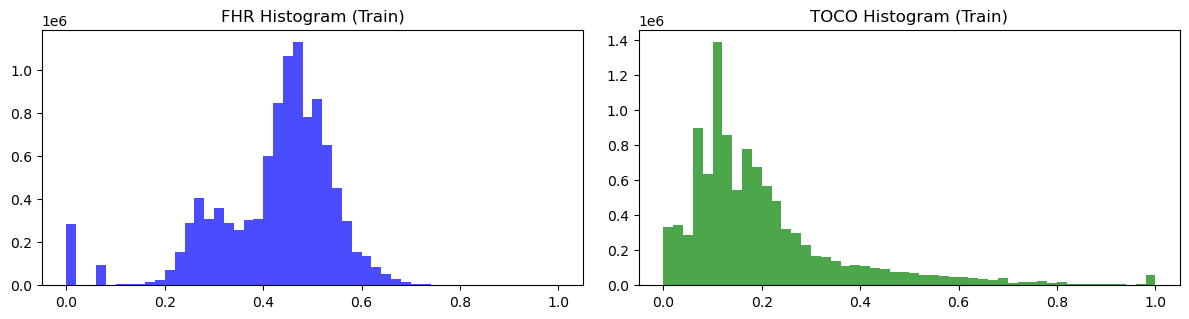

In [11]:
# Normalize using min-max normalization (ignoring -1)
X_train_fhr = min_max_normalize(X_train_fhr, 50.0, 240.0)
X_val_fhr = min_max_normalize(X_val_fhr, 50.0, 240.0)
X_train_toco = min_max_normalize(X_train_toco, 0.0, 100.0)
X_val_toco = min_max_normalize(X_val_toco, 0.0, 100.0)

# Filter out the -1 values for range calculations and plotting
valid_fhr_train = X_train_fhr[X_train_fhr != -1]
valid_toco_train = X_train_toco[X_train_toco != -1]
print('FHR range (excluding -1s):', np.min(valid_fhr_train), '-', np.max(valid_fhr_train),
      '; -1s (%):', np.sum(X_train_fhr == -1) / X_train_fhr.size)
print('TOCO range (excluding -1s):', np.min(valid_toco_train), '-', np.max(valid_toco_train),
      '; -1s (%):', np.sum(X_train_toco == -1) / X_train_toco.size)

# Plot histograms, excluding -1 values for FHR and TOCO
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.hist(valid_fhr_train.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('FHR Histogram (Train)')
plt.subplot(2, 2, 2)
plt.hist(valid_toco_train.flatten(), bins=50, color='green', alpha=0.7)
plt.title('TOCO Histogram (Train)')
plt.tight_layout()
plt.show()

In [12]:
# Merge FHR and TOCO into a single array with shape (N, 960, 2) and add to dataframes
X_train = np.stack((X_train_fhr, X_train_toco), axis=-1)  
X_val = np.stack((X_val_fhr, X_val_toco), axis=-1)   
clinical_train['input_signals'] = [x for x in X_train]
clinical_train['label'] = y_train.tolist()
clinical_val['input_signals'] = [x for x in X_val]
clinical_val['label'] = y_val.tolist()

print(clinical_train.shape, clinical_val.shape)
print('FHR range:', np.min(X_train[:,:,0]), '-', np.max(X_train[:,:,0]), '; -1s:', np.sum(X_train[:,:,0] == -1)/X_train[:,:,0].size)
print('TOCO range:', np.min(X_train[:,:,1]), '-', np.max(X_train[:,:,1]), '; -1s:', np.sum(X_train[:,:,1] == -1)/X_train[:,:,1].size)

(16471, 21) (4118, 21)
FHR range: -1.0 - 1.0 ; -1s: 0.34502509461072994
TOCO range: -1.0 - 1.0 ; -1s: 0.33759777285329773


--------------------------------- Training Set ---------------------------------
Count: 16471



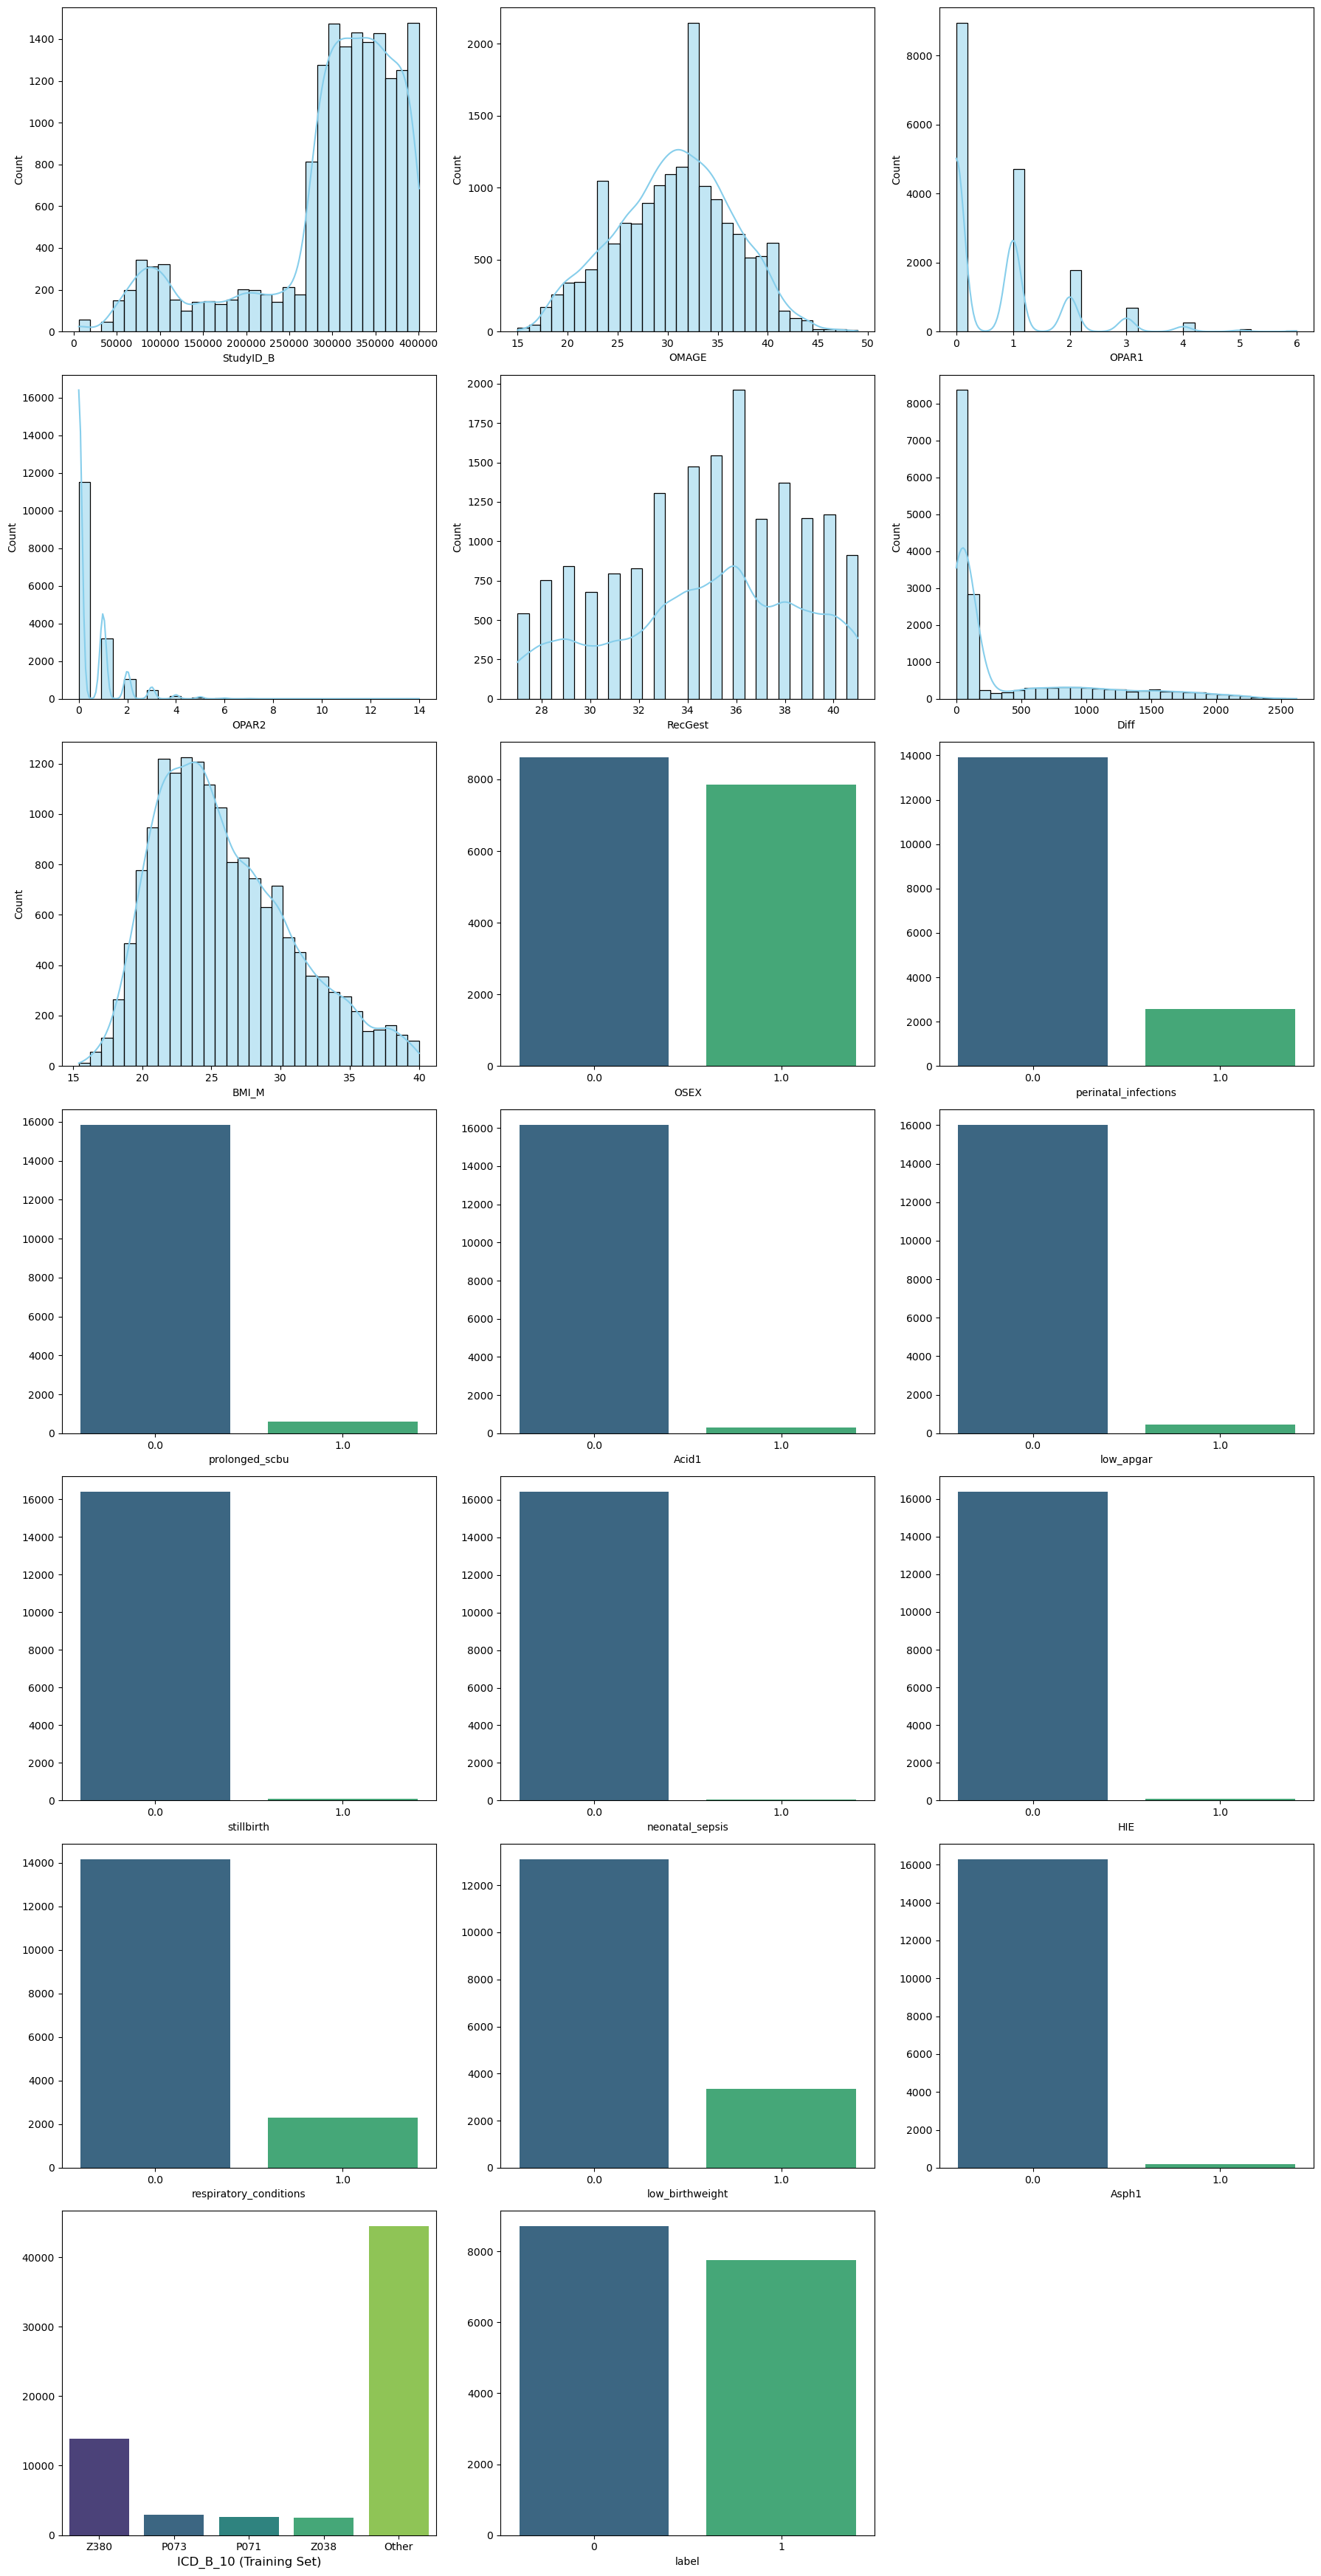

                Column Type/Unique Values                                                                         Details
             StudyID_B            Numeric Min: 5716.00, Max: 400504.00, Mean: 298189.21, Median: 320867.00, Std: 89118.52
                 OMAGE            Numeric                   Min: 15.00, Max: 49.00, Mean: 30.66, Median: 31.00, Std: 5.82
                 OPAR1            Numeric                       Min: 0.00, Max: 6.00, Mean: 0.72, Median: 0.00, Std: 0.99
                 OPAR2            Numeric                      Min: 0.00, Max: 14.00, Mean: 0.47, Median: 0.00, Std: 0.91
               RecGest            Numeric                   Min: 27.00, Max: 41.00, Mean: 34.79, Median: 35.00, Std: 3.85
                  Diff            Numeric               Min: 0.00, Max: 2618.00, Mean: 392.81, Median: 84.00, Std: 582.22
                 BMI_M            Numeric                   Min: 15.42, Max: 40.00, Mean: 25.88, Median: 24.94, Std: 4.86
                  OSEX  

In [16]:
explore_data_results(clinical_train, plots=True, name='Training Set')

--------------------------------- Val/Test Set ---------------------------------
Count: 4118



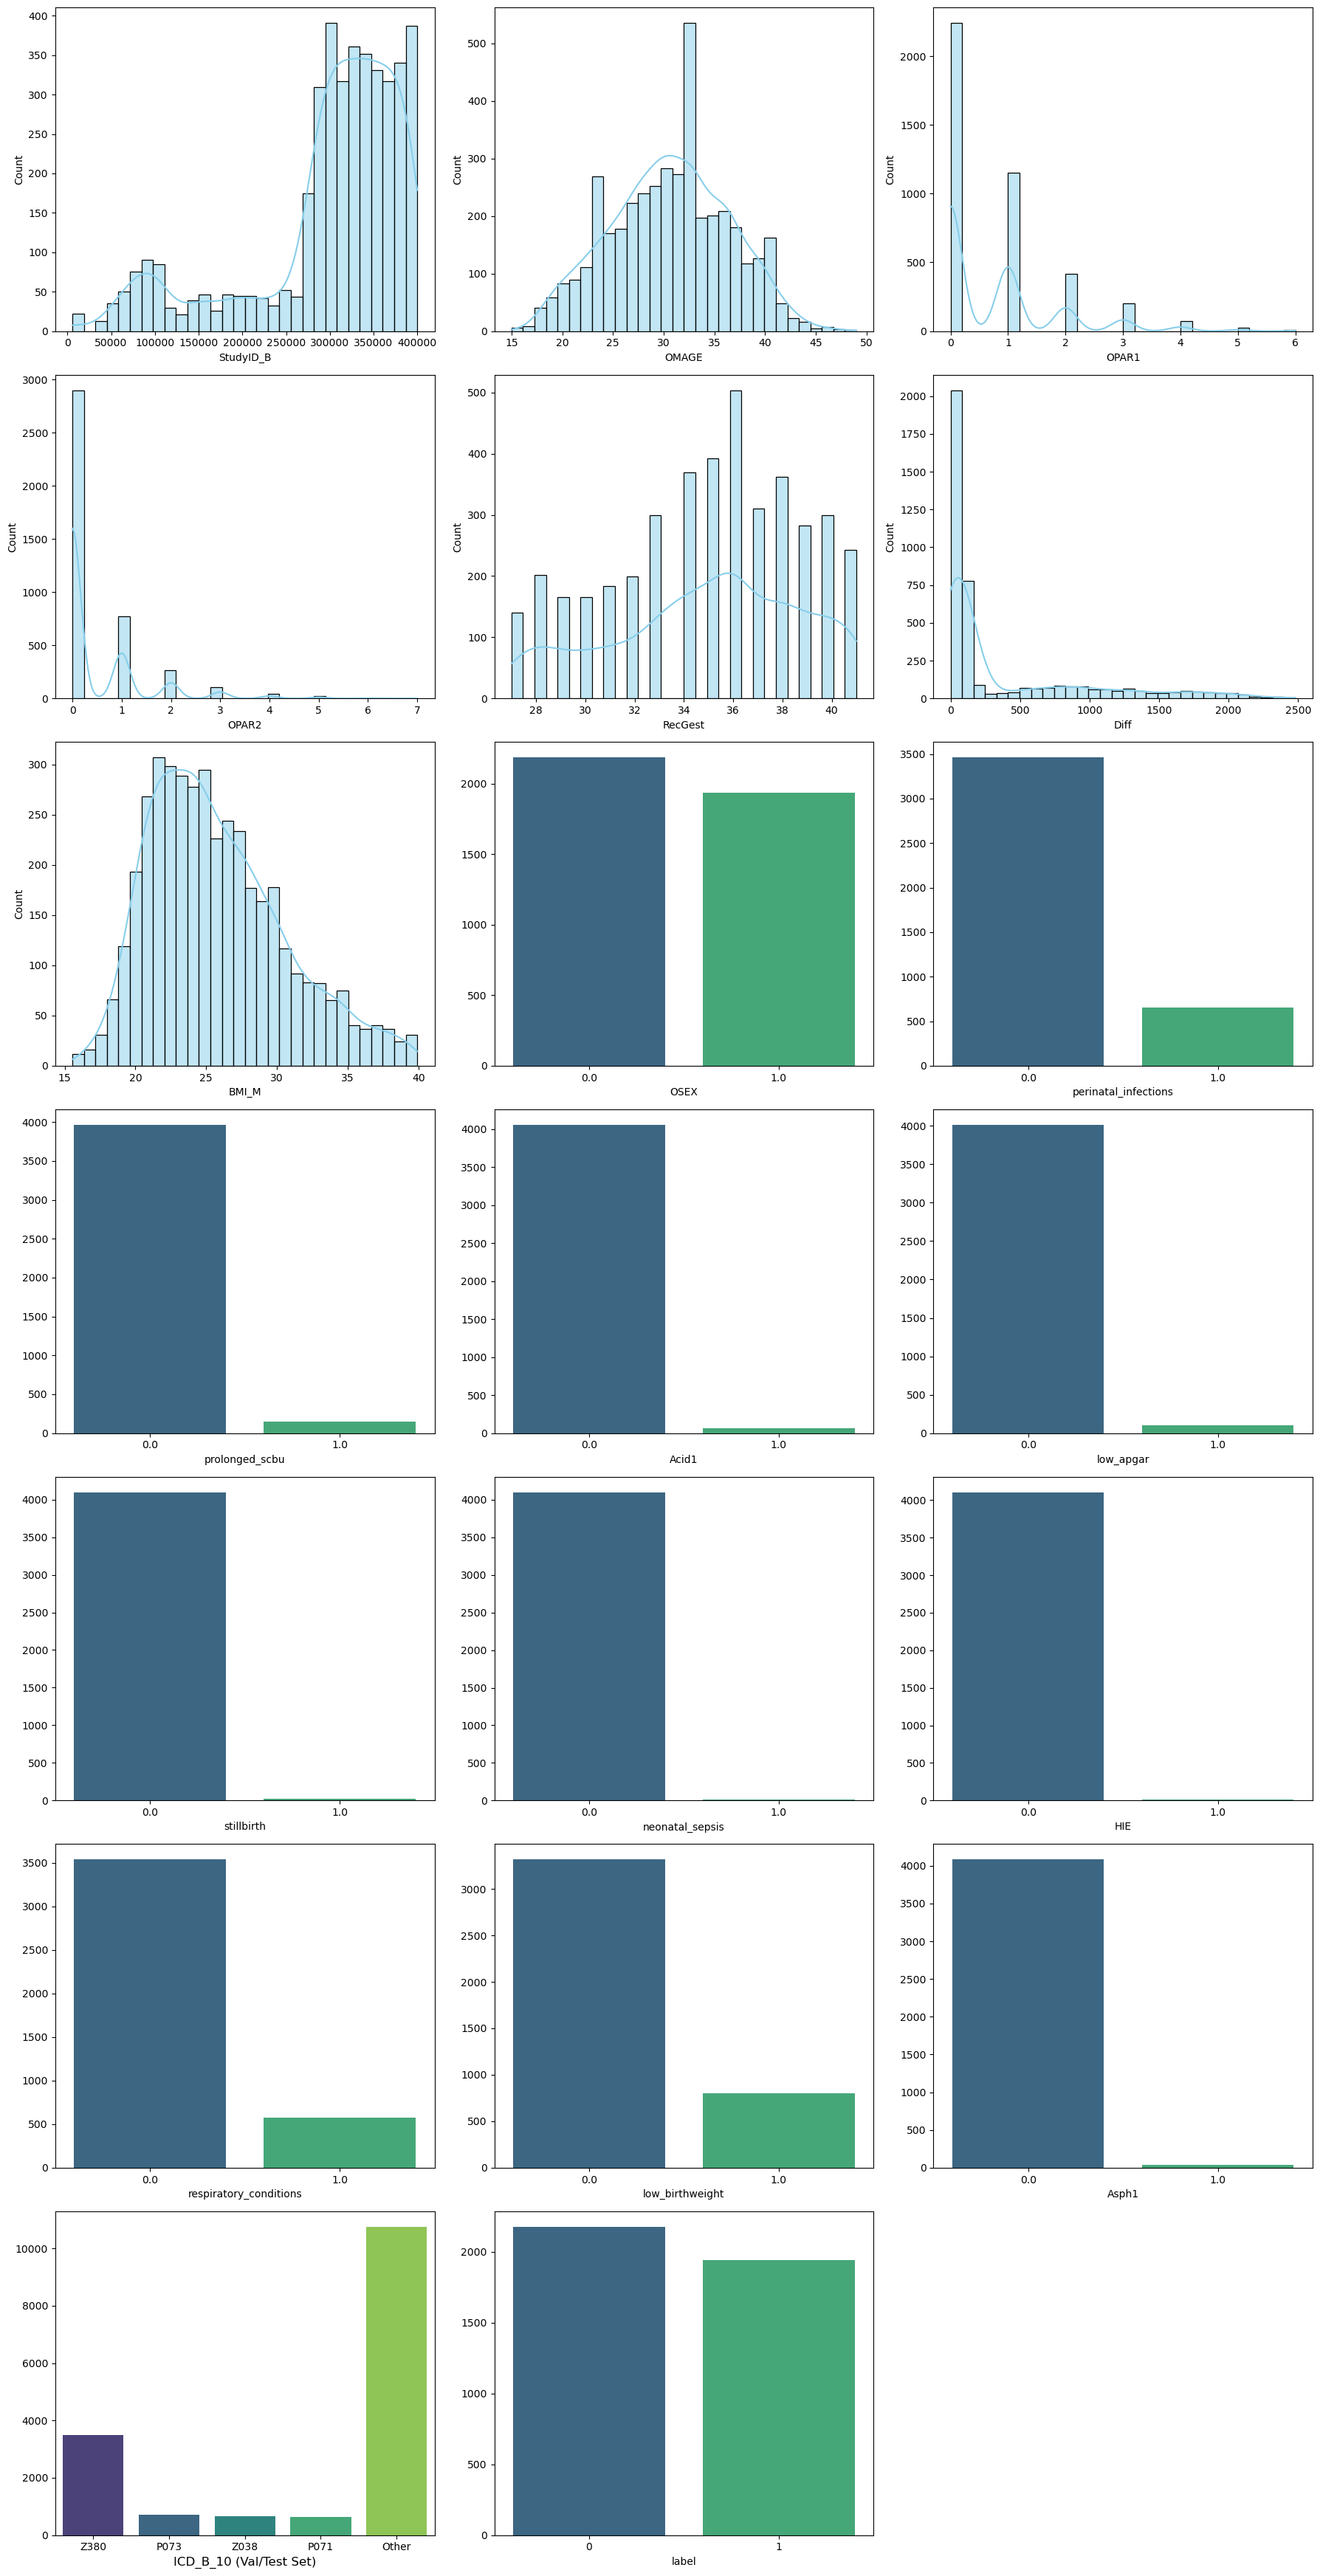

                Column Type/Unique Values                                                                         Details
             StudyID_B            Numeric Min: 5736.00, Max: 399963.00, Mean: 298377.78, Median: 322539.00, Std: 90254.54
                 OMAGE            Numeric                   Min: 15.00, Max: 49.00, Mean: 30.61, Median: 31.00, Std: 5.84
                 OPAR1            Numeric                       Min: 0.00, Max: 6.00, Mean: 0.74, Median: 0.00, Std: 1.04
                 OPAR2            Numeric                       Min: 0.00, Max: 7.00, Mean: 0.47, Median: 0.00, Std: 0.89
               RecGest            Numeric                   Min: 27.00, Max: 41.00, Mean: 34.91, Median: 35.00, Std: 3.85
                  Diff            Numeric               Min: 0.00, Max: 2481.00, Mean: 380.95, Median: 85.00, Std: 575.06
                 BMI_M            Numeric                   Min: 15.55, Max: 39.92, Mean: 25.79, Median: 24.93, Std: 4.80
                  OSEX  

In [17]:
explore_data_results(clinical_val, plots=True, name='Val/Test Set')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


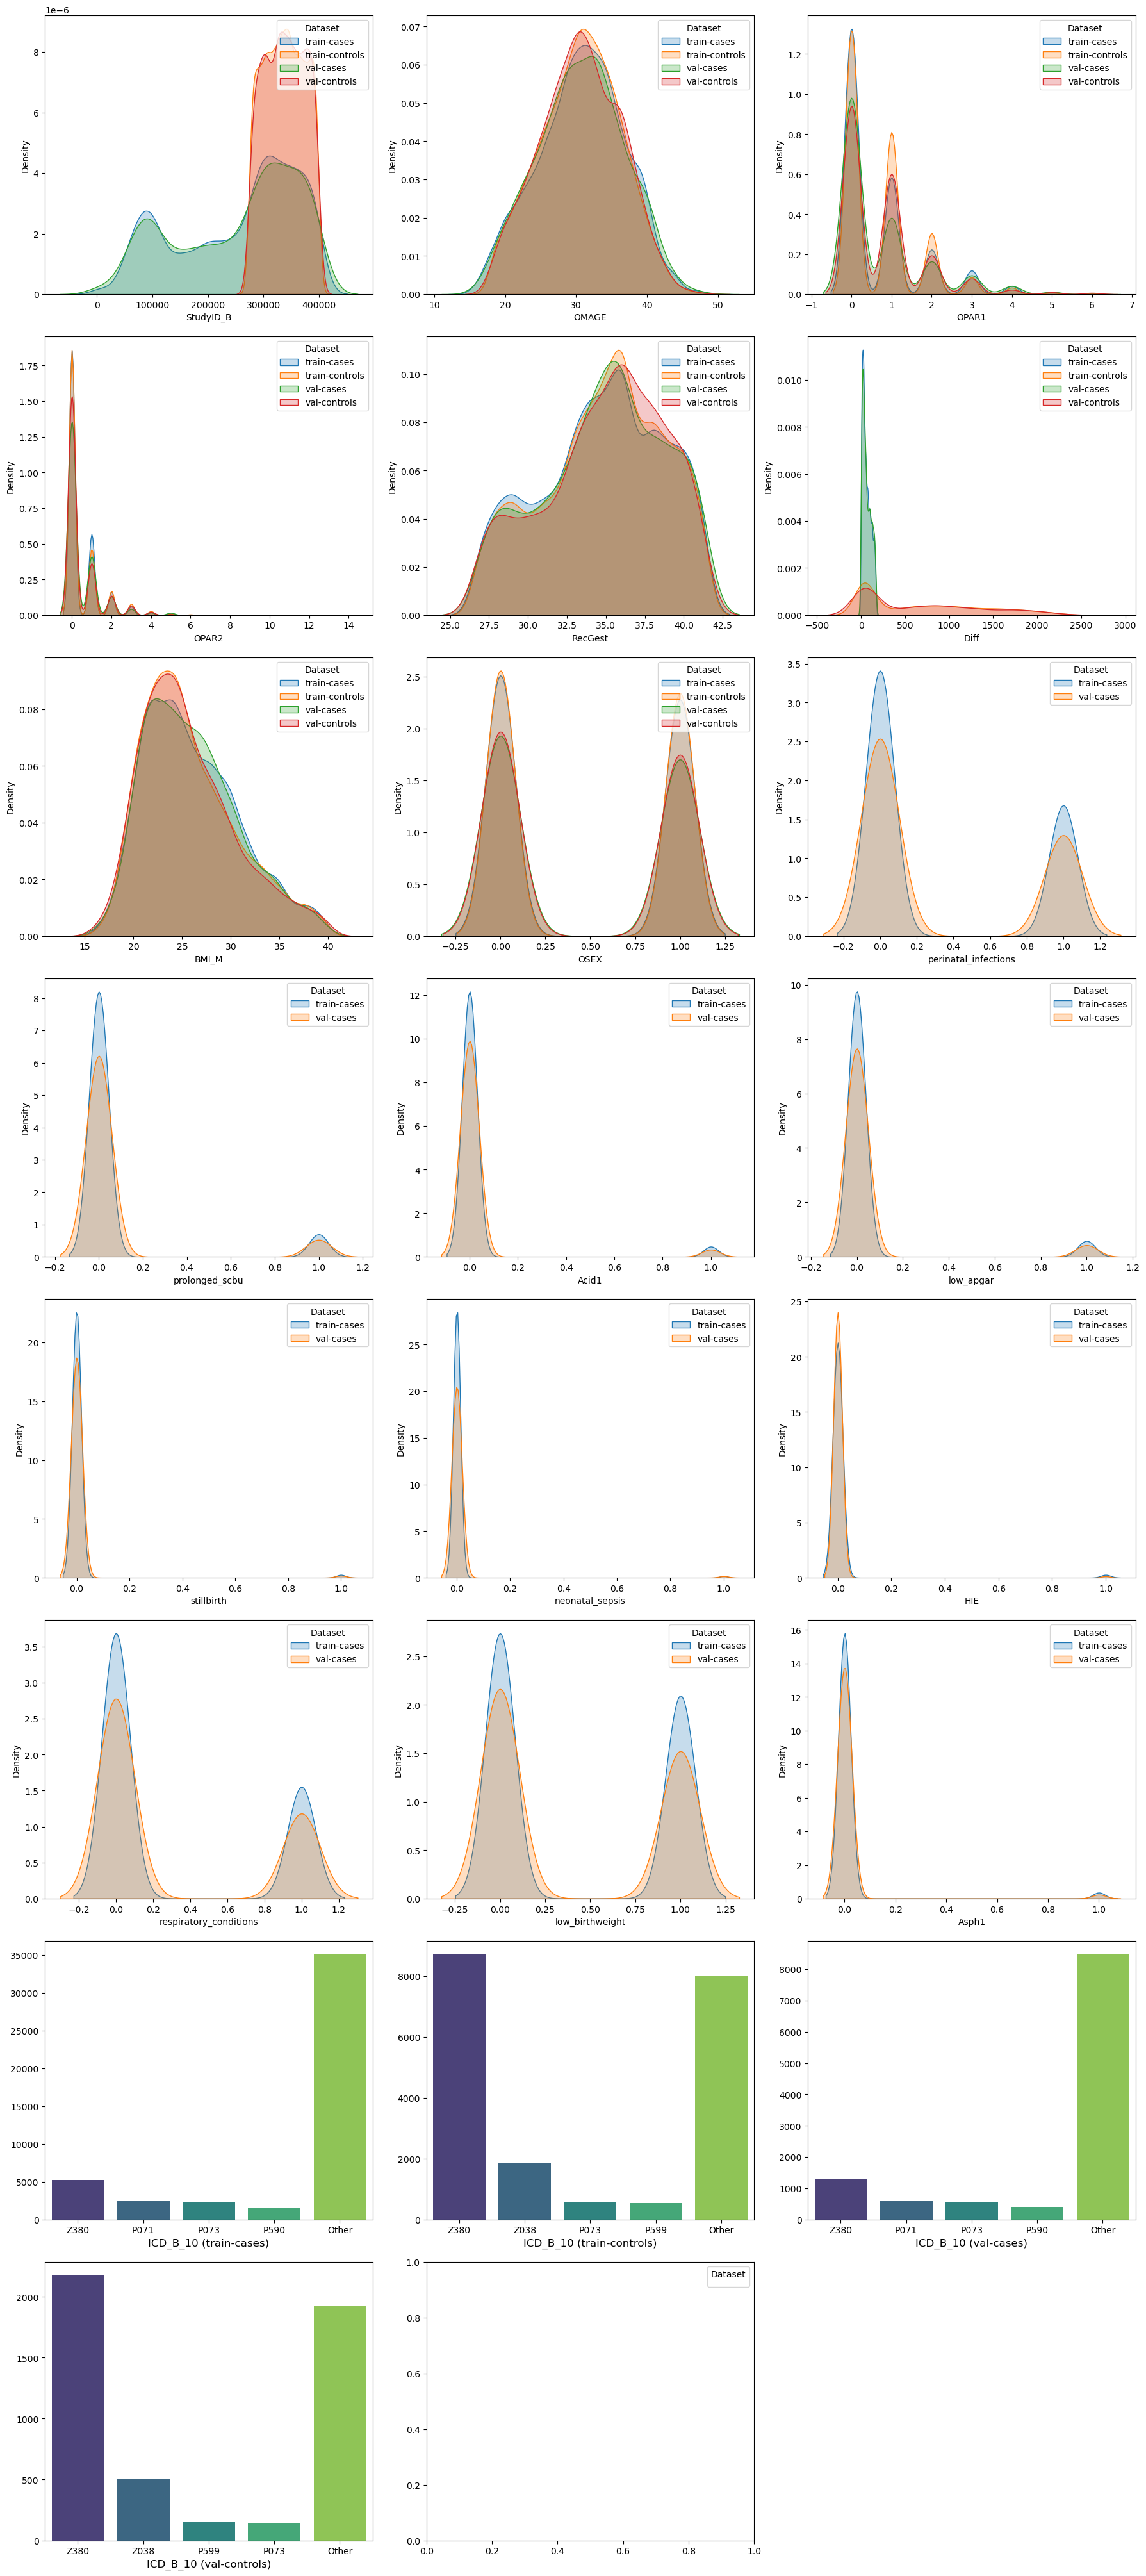

--------------------------------- train-cases ----------------------------------
Count: 7759

                Column Type/Unique Values                                                                          Details
             StudyID_B            Numeric Min: 5716.00, Max: 397491.00, Mean: 254091.41, Median: 288078.00, Std: 108450.35
                 OMAGE            Numeric                    Min: 15.00, Max: 49.00, Mean: 30.71, Median: 31.00, Std: 6.01
                 OPAR1            Numeric                        Min: 0.00, Max: 6.00, Mean: 0.71, Median: 0.00, Std: 1.03
                 OPAR2            Numeric                        Min: 0.00, Max: 9.00, Mean: 0.47, Median: 0.00, Std: 0.89
               RecGest            Numeric                    Min: 27.00, Max: 41.00, Mean: 34.73, Median: 35.00, Std: 3.90
                  Diff            Numeric                   Min: 0.00, Max: 168.00, Mean: 62.07, Median: 51.00, Std: 46.63
                 BMI_M            Numeric    

In [18]:
compare_data_results(clinical_train[clinical_train['label']==1],clinical_train[clinical_train['label']==0],
                     clinical_val[clinical_val['label']==1], clinical_val[clinical_val['label']==0], 
                     names=['train-cases','train-controls','val-cases','val-controls'])

__Clinical Variables:__

- _StudyID_B_: Anonymised, unique identifier for babies. 

- _OPAR1 (Viable Parity)_: Number of times the mother has given birth to a live baby after at least 24 weeks. A higher parity can influence maternal uterine contractility and CTG patterns. In the dataset, the range is 0-6 with a mean of 0.72, suggesting that most mothers have had few prior births. In cases, the mean is slightly lower at 0.71.

- _OPAR2 (Non-Viable Parity)_: Number of pregnancies reaching 24 weeks that did not result in a live birth. This may indicate a history of complicated pregnancies. In the dataset, the range is 0-14 with a mean of 0.47. In cases, the mean is 0.48, slightly higher than in the overall dataset.

- _Diff_: Duration, in hours, from CTG recording to birth. Prolonged labor can cause fetal distress, reflected in abnormal CTG patterns. The dataset has a wide range (0 to 2618 hours) with a mean of 390.44 hours. In cases, the mean is significantly lower at 62.35 hours, as this dataset contains only cases with CTGs recorded 7 days (0 - 168 hours) before birth. 

- _BMI_M_: Mother's BMI at the start of pregnancy. A higher BMI is linked to pregnancy complications and abnormal CTG patterns. In the dataset, BMI ranges from 15.42 to 40.00 with a mean of 25.86. In cases, the mean is slightly higher at 26.03.

- _OSEX (Baby's Sex)_: Baby's assigned sex (0 for male, 1 for female). Some studies suggest that male fetuses may have slightly different CTG patterns compared to females, particularly in response to labor stress. In the dataset, the sample is balanced (10,802 males and 9,787 females). In cases, 5,099 are male and 4,600 are female.

- _Perinatal Infections_: Indicates if the mother had infections during the perinatal period. Infections can lead to fetal distress and abnormal CTG patterns. In the dataset, infections are present in 3,215 cases.

- _Prolonged SCBU_: Whether the baby required extended special care after delivery. Babies requiring prolonged SCBU care might have had compromised conditions that were detectable on the CTG. In the dataset, 760 cases needed SCBU care. 

- _Acid1_: Measure of neonatal acidosis, an indicator of fetal hypoxia. It indicates the baby may not be getting enough oxygen. In the dataset, acidosis is present in 352 cases. 

- _Low Apgar_: Indicates if the newborn's Apgar score at 1 and 5 minutes after birth falls below normal thresholds, signaling health concerns. In the dataset, 543 cases show low Apgar scores.

- _Stillbirth_: Indicates if the baby was stillborn. Abnormal CTG patterns are often associated with cases of stillbirth, especially if there are signs of chronic hypoxia. In the dataset, there are 103 stillbirths.

- _Neonatal Sepsis_: Indicates if the baby developed sepsis shortly after birth. Sepsis can severely affect fetal heart rate patterns, potentially showing signs of infection and distress on the CTG. In the dataset, there are 68 cases of sepsis. 

- _HIE (Hypoxic-Ischemic Encephalopathy)_: Indicates if the newborn was diagnosed with HIE, a brain injury caused by limited oxygen during birth. HIE is present in 108 cases in the dataset.

- _Respiratory Conditions_: Indicates if the baby had respiratory complications. Respiratory distress is often correlated with abnormal CTG patterns, particularly decelerations in the fetal heart rate. In the dataset, 2,878 cases show respiratory issues.

- _Low Birth Weight_: Babies born with weight below the normal threshold. Low birth weight can be associated with intrauterine growth restriction (IUGR), which may lead to abnormal CTG readings. In the dataset, 4,164 cases show low birth weight. 

- _Asph1_: Indicates asphyxia at birth. Fetal asphyxia is a critical condition, often detectable through non-reassuring CTG patterns like late decelerations or reduced variability. In the dataset, 207 cases show asphyxia. 

- _ICD_B_10_: International Classification of Diseases, 10th Revision (ICD-10) codes assigned to the baby. These codes summarize the clinical diagnosis and outcomes, and they can help correlate specific CTG patterns with clinical diagnoses. The most common codes in the dataset include Z380 (17,390 samples), P073 (3,596 samples), and P071 (3,225 samples). In cases, Z380 (birth) occurs 6,500 times, P071 (preterm birth) 3,028 times, and P073 (fetal growth restriction) 2,862 times. In controls, Z380 (birth) occurs 10,890 times, with other codes like Z038 (observations without diagnosis) and P599 (disorders of blood) also appearing frequently.
blood) also appearing frequently.


## Splitting dataset based on 'diff'

In [3]:
def filter_dataset(X_fhr, X_toco, y, clinical, min_diff, max_diff):
    # Create a boolean mask for the condition: y == 1 and Diff outside the [min_diff, max_diff] range
    mask = ~((y == 1) & ((clinical['Diff'] < min_diff) | (clinical['Diff'] > max_diff)))
    
    # Filter the data using the mask
    X_fhr_filtered = X_fhr[mask]
    X_toco_filtered = X_toco[mask]
    y_filtered = y[mask]
    clinical_filtered = clinical[mask]

    print(X_fhr.shape,X_toco.shape,y.shape,clinical.shape,
          'Cases Diff: (',min(clinical[y==1]['Diff']),',',max(clinical[y==1]['Diff']),')')
    print(X_fhr_filtered.shape,X_toco_filtered.shape,y_filtered.shape,clinical_filtered.shape,
          'Cases Diff: (',min(clinical_filtered[y_filtered==1]['Diff']),',',max(clinical_filtered[y_filtered==1]['Diff']),')')
    print('------------------------------')
    
    return X_fhr_filtered, X_toco_filtered, y_filtered, clinical_filtered

### Old Dataset (~20k CTGs)

In [189]:
dataset_path = "ctg_dataset/Old Dataset"
X_train_fhr = np.load(os.path.join(dataset_path, 'X_train_fhr.npy'))
X_train_toco = np.load(os.path.join(dataset_path, 'X_train_toco.npy'))
y_train = np.load(os.path.join(dataset_path, 'y_train.npy'))
clinical_train = pd.read_csv(os.path.join(dataset_path, 'clinical_train.csv'))
X_val_fhr = np.load(os.path.join(dataset_path, 'X_val_fhr.npy'))
X_val_toco = np.load(os.path.join(dataset_path, 'X_val_toco.npy'))
y_val = np.load(os.path.join(dataset_path, 'y_val.npy'))
clinical_val = pd.read_csv(os.path.join(dataset_path, 'clinical_val.csv'))

In [190]:
print('Cases Diff:    (',min(clinical_train[y_train==1]['Diff']),',',max(clinical_train[y_train==1]['Diff']),')')
print('Cases Diff:    (',min(clinical_val[y_val==1]['Diff']),',',max(clinical_val[y_val==1]['Diff']),')')
print('Controls Diff: (',min(clinical_train[y_train==0]['Diff']),',',max(clinical_train[y_train==0]['Diff']),')')
print('Controls Diff: (',min(clinical_val[y_val==0]['Diff']),',',max(clinical_val[y_val==0]['Diff']),')')

Cases Diff:    ( 0.0 , 168.0 )
Cases Diff:    ( 0.0 , 168.0 )
Controls Diff: ( 1.0 , 2618.0 )
Controls Diff: ( 1.0 , 2481.0 )


In [169]:
dataset_path_filtered = f'{dataset_path} (Cases Diff 3-7)'
os.mkdir(dataset_path_filtered)

# Apply filtering to the training set
X_train_fhr_filtered, X_train_toco_filtered, y_train_filtered, clinical_train_filtered = filter_dataset(
    X_train_fhr, X_train_toco, y_train, clinical_train, 3*24, 7*24)

# Apply filtering to the validation set
X_val_fhr_filtered, X_val_toco_filtered, y_val_filtered, clinical_val_filtered = filter_dataset(
    X_val_fhr, X_val_toco, y_val, clinical_val, 3*24, 7*24)

# Define the output filenames
output_train_fhr = os.path.join(dataset_path_filtered, 'X_train_fhr.npy')
output_train_toco = os.path.join(dataset_path_filtered, 'X_train_toco.npy')
output_y_train = os.path.join(dataset_path_filtered, 'y_train.npy')
output_clinical_train = os.path.join(dataset_path_filtered, 'clinical_train.csv')
output_val_fhr = os.path.join(dataset_path_filtered, 'X_val_fhr.npy')
output_val_toco = os.path.join(dataset_path_filtered, 'X_val_toco.npy')
output_y_val = os.path.join(dataset_path_filtered, 'y_val.npy')
output_clinical_val = os.path.join(dataset_path_filtered, 'clinical_val.csv')

# Save the filtered datasets
np.save(output_train_fhr, X_train_fhr_filtered)
np.save(output_train_toco, X_train_toco_filtered)
np.save(output_y_train, y_train_filtered)
clinical_train_filtered.to_csv(output_clinical_train, index=False)
np.save(output_val_fhr, X_val_fhr_filtered)
np.save(output_val_toco, X_val_toco_filtered)
np.save(output_y_val, y_val_filtered)
clinical_val_filtered.to_csv(output_clinical_val, index=False)

(16471, 960) (16471, 960) (16471,) (16471, 19) Cases Diff: ( 0.0 , 168.0 )
(11656, 960) (11656, 960) (11656,) (11656, 19) Cases Diff: ( 72.0 , 168.0 )
------------------------------
(4118, 960) (4118, 960) (4118,) (4118, 19) Cases Diff: ( 0.0 , 168.0 )
(2928, 960) (2928, 960) (2928,) (2928, 19) Cases Diff: ( 72.0 , 168.0 )
------------------------------


In [172]:
dataset_path_filtered = f'{dataset_path} (Cases Diff 0-2)'
os.mkdir(dataset_path_filtered)

# Apply filtering to the training set
X_train_fhr_filtered, X_train_toco_filtered, y_train_filtered, clinical_train_filtered = filter_dataset(
    X_train_fhr, X_train_toco, y_train, clinical_train, 0*24, 2*24)

# Apply filtering to the validation set
X_val_fhr_filtered, X_val_toco_filtered, y_val_filtered, clinical_val_filtered = filter_dataset(
    X_val_fhr, X_val_toco, y_val, clinical_val, 0*24, 2*24)

# Define the output filenames
output_train_fhr = os.path.join(dataset_path_filtered, 'X_train_fhr.npy')
output_train_toco = os.path.join(dataset_path_filtered, 'X_train_toco.npy')
output_y_train = os.path.join(dataset_path_filtered, 'y_train.npy')
output_clinical_train = os.path.join(dataset_path_filtered, 'clinical_train.csv')
output_val_fhr = os.path.join(dataset_path_filtered, 'X_val_fhr.npy')
output_val_toco = os.path.join(dataset_path_filtered, 'X_val_toco.npy')
output_y_val = os.path.join(dataset_path_filtered, 'y_val.npy')
output_clinical_val = os.path.join(dataset_path_filtered, 'clinical_val.csv')

# Save the filtered datasets
np.save(output_train_fhr, X_train_fhr_filtered)
np.save(output_train_toco, X_train_toco_filtered)
np.save(output_y_train, y_train_filtered)
clinical_train_filtered.to_csv(output_clinical_train, index=False)
np.save(output_val_fhr, X_val_fhr_filtered)
np.save(output_val_toco, X_val_toco_filtered)
np.save(output_y_val, y_val_filtered)
clinical_val_filtered.to_csv(output_clinical_val, index=False)

(16471, 960) (16471, 960) (16471,) (16471, 19) Cases Diff: ( 0.0 , 168.0 )
(12448, 960) (12448, 960) (12448,) (12448, 19) Cases Diff: ( 0.0 , 48.0 )
------------------------------
(4118, 960) (4118, 960) (4118,) (4118, 19) Cases Diff: ( 0.0 , 168.0 )
(3107, 960) (3107, 960) (3107,) (3107, 19) Cases Diff: ( 0.0 , 48.0 )
------------------------------


### New Dataset (~10k CTGs)

In [193]:
dataset_path = "ctg_dataset/Dataset with Folds/model_datasets/fold_0"
X_train_fhr = np.load(os.path.join(dataset_path, 'X_train_fhr.npy'))
X_train_toco = np.load(os.path.join(dataset_path, 'X_train_toco.npy'))
y_train = np.load(os.path.join(dataset_path, 'y_train.npy'))
clinical_train = pd.read_csv(os.path.join(dataset_path, 'clinical_train.csv'))
X_val_fhr = np.load(os.path.join(dataset_path, 'X_val_fhr.npy'))
X_val_toco = np.load(os.path.join(dataset_path, 'X_val_toco.npy'))
y_val = np.load(os.path.join(dataset_path, 'y_val.npy'))
clinical_val = pd.read_csv(os.path.join(dataset_path, 'clinical_val.csv'))

/tmp/ipykernel_6036/758706829.py:5: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  clinical_train = pd.read_csv(os.path.join(dataset_path, 'clinical_train.csv'))


In [194]:
print('Cases Diff:    (',min(clinical_train[y_train==1]['Diff']),',',max(clinical_train[y_train==1]['Diff']),')')
print('Cases Diff:    (',min(clinical_val[y_val==1]['Diff']),',',max(clinical_val[y_val==1]['Diff']),')')
print('Controls Diff: (',min(clinical_train[y_train==0]['Diff']),',',max(clinical_train[y_train==0]['Diff']),')')
print('Controls Diff: (',min(clinical_val[y_val==0]['Diff']),',',max(clinical_val[y_val==0]['Diff']),')')

Cases Diff:    ( 0.0 , 48.0 )
Cases Diff:    ( 0.0 , 48.0 )
Controls Diff: ( 1.0 , 2590.0 )
Controls Diff: ( 2.0 , 2470.0 )
